In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import os
import torch as t
import datetime
import transformers
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", device=0) ## device = 0 forces it to use GPU

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/MyDrive/datax/Data dump")
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
test0.csv      test20000.csv  test40000.csv  test60000.csv  test80000.csv
test10000.csv  test30000.csv  test50000.csv  test70000.csv  test90000.csv


In [ ]:
batch_0 = pd.read_csv("test0.csv")
batch_1 = pd.read_csv("test10000.csv")
batch_2 = pd.read_csv("test20000.csv")
batch_3 = pd.read_csv("test30000.csv")
batch_4 = pd.read_csv("test40000.csv")
batch_5 = pd.read_csv("test50000.csv")
batch_6 = pd.read_csv("test60000.csv")
batch_7 = pd.read_csv("test70000.csv")
batch_8 = pd.read_csv("test80000.csv")
batch_9 = pd.read_csv("test90000.csv")

In [ ]:
all_batches = pd.concat([batch_0, batch_1, batch_2, batch_3, batch_4, batch_5, batch_6, batch_7, batch_8, batch_9])

In [ ]:
all_batches.head()

,business_id,review_id,text,label,score
0,Pkp824mx2LL93TqKOdfMyQ,LnaPCqkhodibGlnboI4ccw,The Jajangmyeon noodles entree is decent. The ...,bad customer service,0.995263
1,Pkp824mx2LL93TqKOdfMyQ,LnaPCqkhodibGlnboI4ccw,The Jajangmyeon noodles entree is decent. The ...,unfriendly,0.958487
2,Pkp824mx2LL93TqKOdfMyQ,LnaPCqkhodibGlnboI4ccw,The Jajangmyeon noodles entree is decent. The ...,bad ambience,0.826795
3,Pkp824mx2LL93TqKOdfMyQ,LnaPCqkhodibGlnboI4ccw,The Jajangmyeon noodles entree is decent. The ...,small portion,0.310150
4,Pkp824mx2LL93TqKOdfMyQ,LnaPCqkhodibGlnboI4ccw,The Jajangmyeon noodles entree is decent. The ...,long wait time,0.250917


In [ ]:
os.chdir("/content/drive/MyDrive/datax/labeled")
labelled_df = pd.read_excel('all_labelled_w_stars.xlsx')

In [ ]:
labelled_df.head()

,review_id,user_id,business_id,text,expensive,bad_customer_service,small_portion_size,poor_ambience,bad_food_taste,stars
0,pnFdVwKiWaeA8NeDOvpOiQ,SRK2U3ABA8_69HaPpG-TVw,nNLO8Tb8YpzbueWDvsBujw,Great tacos and great service! They're nestled...,0,0,0,0,0,5
1,BgKQbH0MKkTsrijSw6Zkvg,wftsECzG0zPtTrjj27HeDw,Uh12SFBz8QH2kRqlaQzJXA,We were staying in the hotel and were excited ...,0,1,0,1,0,1
2,tHwu8jZIb2lUA63oJ04syw,5eKw3008O68CColZ0UymXg,e--ZBDeTnCCus211ey0oaw,The worst manager that thinks their customers ...,0,1,0,0,1,1
3,hZdhryBPdQdh5QOiNgIKOA,5BCI6MPXBMzednGzWyFWeg,o99z52tHMSIj4wuo6T9DMw,My man and I decided to check this place out f...,0,0,0,0,1,4
4,OQMHntlbXkklps97G5C3QA,zVftvfIB2rDSf1YHeTTgog,wST1xUmufNGgJXPunoDZyg,I come here pretty regularly and really enjoy ...,0,0,0,0,0,5


In [ ]:
expensive = ["expensive"]
bad_customer_service = ["bad customer service", "long wait time", "unfriendly"]
poor_ambience = ["bad ambience", "dirty", "crowded"]
small_portion_size = ["small portion"]
bad_food_taste = ["bad food taste", "overcooked", "undercooked", "bad drinks"]
all_category = expensive + bad_customer_service + bad_ambience + small_portion + poor_food_quality

In [ ]:
def thresholder_category(df_predict, tags, category, threshold=0.5):
  df_final = df_predict.copy()
  df = df_predict.copy()
  df['flag'] = np.where(df['score'] >= threshold, 1, 0)
  df_tags_interest = df[df['label'].isin(tags)]
  df_revs_positive_cat = df_tags_interest[df_tags_interest['flag'] == 1]
  df_final.drop_duplicates(['review_id'], inplace=True) ## dropping same category
  df_final[category] = np.where(df_final['review_id'].isin(df_revs_positive_cat['review_id']), 1, 0)
  return df_final[['review_id', 'business_id', category]]

In [ ]:
def prediction_accuracy_2(df_predict, df_label, label):
  
  df_predict.rename(columns={label:'Predict'}, inplace=True)
  df_label.rename(columns={label:'Test'}, inplace=True)
  
  y_pred_test = df_predict.merge(df_label, on=['review_id', 'business_id'], how='inner')
  
  tp = sum((y_pred_test['Test'] == 1) & (y_pred_test['Predict'] == 1))
  tn = sum((y_pred_test['Test'] == 0) & (y_pred_test['Predict'] == 0))
  fp = sum((y_pred_test['Test'] == 0) & (y_pred_test['Predict'] == 1))
  fn = sum((y_pred_test['Test'] == 1) & (y_pred_test['Predict'] == 0))
  
  #TPR, FPR, Accuracy
  TPR = tp/(tp+fn)
  FPR = fp/(fp+tn)
  accuracy = (tp+tn)/(tn+tp+fn+fp)
  
  #Precision, recall
  pr = tp/(tp+fp)
  rc = tp/(tp+fn)
  
  # # print(model_type, " :")
  # print("TPR: ", round(TPR,4))
  # print("FPR: ", round(FPR,4))
  # print("Precision: ", round(pr,4))
  # print("Recall: ", round(rc,4))
  # print("Accuracy: ", round(accuracy,4))
  return TPR, FPR, pr, rc, accuracy

In [ ]:
## plotting pr vs. re
# Note:df is the dataset with all the reviews that need tagging
def plotter_roc(df, df_label, tags, label):
  summary_plot = pd.DataFrame()
  for t in np.arange(0, 1, 0.005):
    df_predict_t = thresholder_category(df, tags, label, t)
    tpr, fpr, pr, rc, accuracy = prediction_accuracy_2(df_predict_t.copy(), df_label.copy(), label)
    plot_temp = pd.DataFrame({'Threshold':[t], 'Precision':[pr], 'Recall':[rc]})
    summary_plot = summary_plot.append(plot_temp)
    
    ## reset index
    summary_plot.reset_index(drop=True, inplace=True) 

  return summary_plot

In [ ]:
expensive_summary = plotter_roc(all_batches, labelled_df, ["expensive"], "expensive")

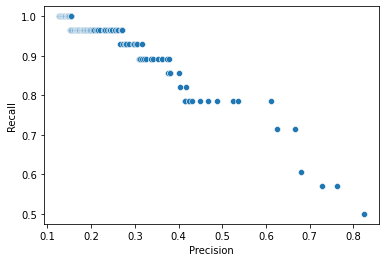

In [ ]:
sns.scatterplot(data=expensive_summary, x="Precision", y="Recall") ## 0.97 for expensive

In [ ]:
bad_customer_service_summary = plotter_roc(all_batches, labelled_df, ["bad customer service", "long wait time", "unfriendly"], "bad_customer_service")

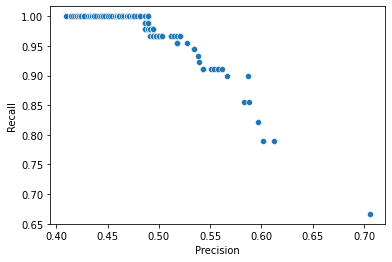

In [ ]:
sns.scatterplot(data=bad_customer_service_summary, x="Precision", y="Recall") ## 0.995 for bad_customer_service

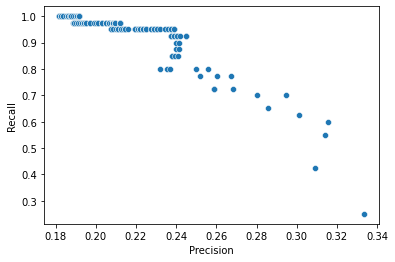

In [ ]:
poor_ambience_summary = plotter_roc(all_batches, labelled_df, ["bad ambience", "dirty", "crowded"], "poor_ambience")
sns.scatterplot(data=poor_ambience_summary, x="Precision", y="Recall") ## 0.99 for poor_ambience

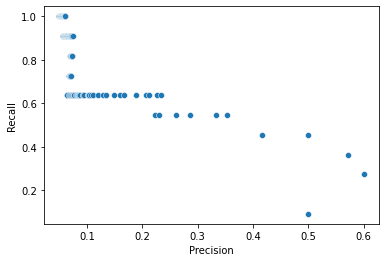

In [ ]:
small_portion_size_summary = plotter_roc(all_batches, labelled_df, ["small portion"], "small_portion_size")
sns.scatterplot(data=small_portion_size_summary, x="Precision", y="Recall") ## 0.995 for small_portion_size

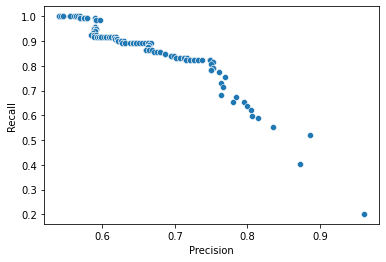

In [ ]:
bad_food_taste_summary = plotter_roc(all_batches, labelled_df, ["bad food taste", "overcooked", "undercooked", "bad drinks"], "bad_food_taste")
sns.scatterplot(data=bad_food_taste_summary, x="Precision", y="Recall") ## 0.945 for bad_food_taste

In [ ]:
## pick threshold for every category
expensive_threshold = 0.97
bad_customer_service_threshold = 0.995
poor_ambience_threshold = 0.99
small_portion_size_threshold = 0.995
bad_food_taste_threshold = 0.945

In [ ]:
## run the threshold function and apply threshold and apply certain tag and get the flag_labels

expensive_flagged = thresholder_category(all_batches, expensive, 'expensive', threshold=expensive_threshold)

bad_customer_service_flagged = thresholder_category(all_batches, bad_customer_service, 'bad_customer_service', threshold=bad_customer_service_threshold)

poor_ambience_flagged = thresholder_category(all_batches, poor_ambience, 'poor_ambience', threshold=poor_ambience_threshold)

small_portion_size_flagged = thresholder_category(all_batches, small_portion_size, "small_portion_size", threshold=small_portion_size_threshold)

bad_food_taste_flagged = thresholder_category(all_batches, bad_food_taste, "bad_food_taste", threshold=bad_food_taste_threshold)

In [ ]:
flagged = [expensive_flagged, bad_customer_service_flagged, poor_ambience_flagged, small_portion_size_flagged, bad_food_taste_flagged]

In [ ]:
for i in flagged:
  print(i.columns[2], round(np.mean(i[i.columns[2]]), 4))

expensive 0.1565
bad_customer_service 0.4239
poor_ambience 0.2332
small_portion_size 0.0137
bad_food_taste 0.4172


In [ ]:
os.chdir("/content/drive/MyDrive/datax")
!ls

 01_reviews_filtering.ipynb   Model_v05_summ.ipynb
 austin_rest.csv	      rest_good_bad_review.csv
 austin_review.csv	      rest_with_good_bad_review.csv
'Data dump'		      sum_review_bus.csv
 example.csv		      zero_shot_test
 labeled


In [ ]:
rev = pd.read_csv('austin_review.csv')
rest = pd.read_csv("austin_rest.csv")

In [ ]:
still_open = rest[rest.is_open == 1]
still_open_rev = rev[rev.business_id.isin(still_open.business_id)]

In [ ]:
## Select resturants that has more than 10 reviews and less than 500 reviews
df_rev_count = still_open_rev.groupby('business_id').agg({'review_id':'count'}).reset_index()
filtered_bid = df_rev_count[(df_rev_count.review_id >= 15) & (df_rev_count.review_id <= 500)]
rev_filtered_df = still_open_rev[still_open_rev.business_id.isin(filtered_bid.business_id)]

In [ ]:
still_open_rev_count_filtered_df = still_open[(still_open.review_count >= 15) & (still_open.review_count <= 500)]

In [ ]:
## Merge
rev_filtered_df = rev_filtered_df.merge(expensive_flagged[['review_id','expensive']], how="left", on="review_id")
rev_filtered_df = rev_filtered_df.merge(bad_customer_service_flagged[['review_id','bad_customer_service']], how="left", on="review_id")
rev_filtered_df = rev_filtered_df.merge(poor_ambience_flagged[['review_id','poor_ambience']], how="left", on="review_id")
rev_filtered_df = rev_filtered_df.merge(small_portion_size_flagged[['review_id','small_portion_size']], how="left", on="review_id")
rev_filtered_df = rev_filtered_df.merge(bad_food_taste_flagged[['review_id','bad_food_taste']], how="left", on="review_id")

In [ ]:
rev_filtered_df = rev_filtered_df.fillna(value={"expensive": 0, "bad_customer_service": 0, "poor_ambience": 0, "small_portion_size": 0, "bad_food_taste": 0})

In [ ]:
## get % of reviews flagged in bid level, reset index ALWAYS for groupby()

for_agg = {'expensive':'mean', 
           'bad_customer_service':'mean', 
           'poor_ambience':'mean', 
           'small_portion_size':'mean', 
           'bad_food_taste':'mean'}

perc_in_cat = rev_filtered_df.groupby(["business_id"]).agg(for_agg).reset_index()

In [ ]:
bus_w_perc = still_open_rev_count_filtered_df.merge(perc_in_cat, how='inner', on='business_id')

In [ ]:
# bus_w_perc.to_csv("bus_with_label_perc.csv", index=False)